# Chapter 3: Time series decomposition

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

In [55]:
import calendar

from coreforecast.scalers import boxcox, boxcox_lambda
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

It's often helpful to decompose a time series into several components, each representing a different underlying pattern category. We can combine the trend and cycle into a single **trend-cycle** component which is often just called the trend for simplicity. Thus we can think of a time series as having three components: a trend-cycle component, seasonal components, and a remainder component. 

When decomposing a time series, it's sometimes helpful to transform or adjust the series to make the decomposition as simple as possible. 

## 3.1 Transformations and adjustments

Four kinds of adjustments:
- calendar
- population
- inflation
- mathematical transformations

The purpose of these is to simplify the patterns in the series by removing known sources of variation, or by making the pattern more consistent across the series. Simpler patterns are usually easier to model and lead to better forecasts. 

### Calendar adjustments 

Some of the variation in seasonal data may be due simply to calendar effects. It's usually easier to remove the variation before doing further analysis.

For example, when looking at total monthly sales in a retail store, there will be variation from month to month simply because of the different number of weekdays in each month in addition to seasonal variation across the year, holidays, etc. We can remove this variation by computing *average sales per trading day* in each month, rather than total sales in the month. This effectively removes the calendar variation. 

### Population adjustments

Data affected by population can be adjusted to give per-capita values. 

Consider the `global_economy` dataset, where we can plot Australian GDP per-capita instead of raw GDP. 

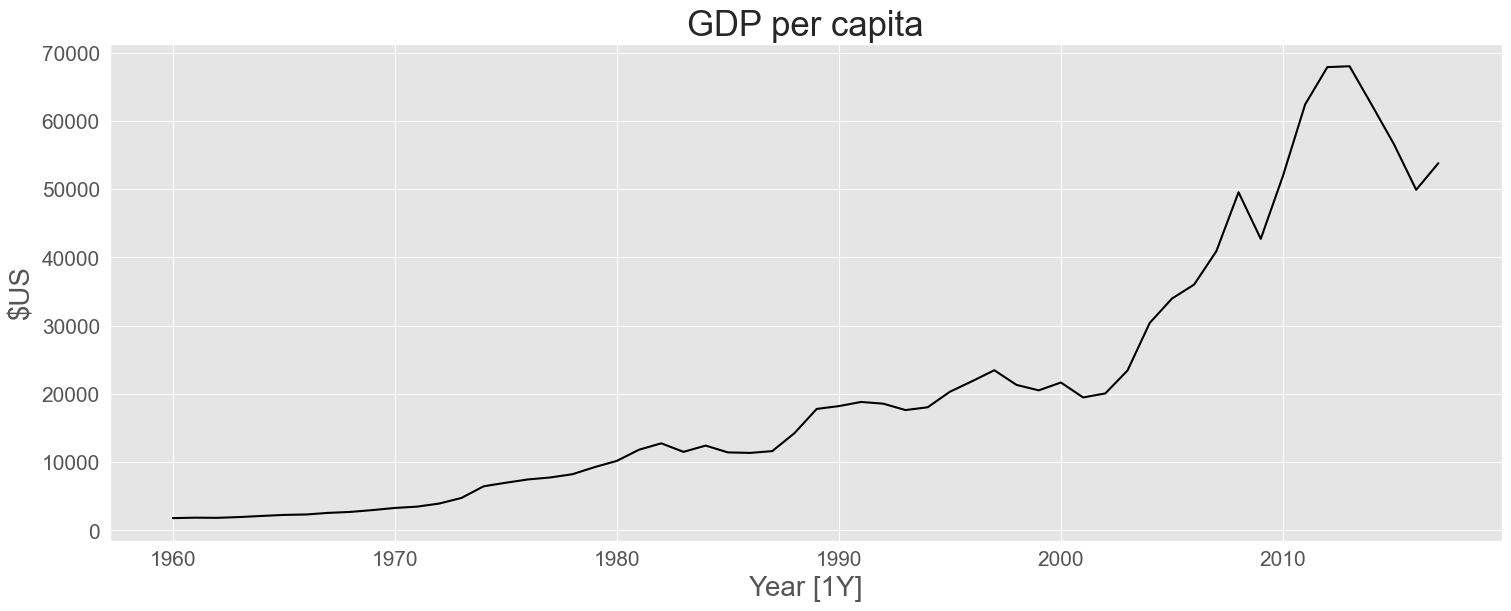

In [3]:
global_economy = pd.read_csv("./data/global_economy.csv")

df = (
    global_economy
    .loc[lambda x: x["unique_id"] == "Australia"]
    .assign(y=lambda x: x["GDP"] / x["Population"])
)
plot_series(df, xlabel="Year [1Y]", ylabel="$US", title="GDP per capita")

### Inflation adjustments 

Data affected by the value of money are best adjusted before modeling. For example, the average cost of a house will have increased over the last few decades due to inflation.

To make these adjustments, a price index is used. If $z_t$ denotes the price index and $y_t$ the original house price in year $t$, then $x_t = y_t / z_t * z_{2000}$ gives the adjusted house price at year 2000 dollar values. 

Consider looking at aggregate annual "newspaper and book" retail turnover from `aus_retail`, and adjusting the data for inflation using the CPI from `global_economy` as below.

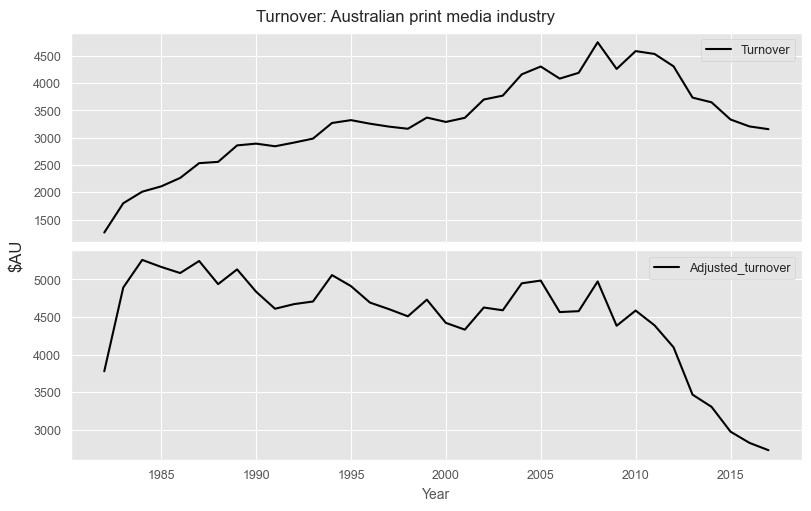

In [4]:
aus_retail = pd.read_csv("./data/aus_retail.csv", parse_dates=["Month"])
print_retail = (
    aus_retail
    .loc[lambda x: x["Industry"] == "Newspaper and book retailing"]
    .assign(ds=lambda x: x["Month"].dt.year)
    .groupby("ds", as_index=False)
    ["Turnover"].sum()
)

aus_economy = global_economy.loc[lambda x: x["unique_id"] == "Australia"]
df = (
    aus_economy
    .merge(print_retail, on="ds", how="left")
    .assign(adjusted_turnover=lambda x: x["Turnover"] / x["CPI"] * 100)
    .dropna()
)

fig, axes = plt.subplots(2, 1, sharex=True)
sns.lineplot(data=df, x='ds', y='Turnover', ax=axes[0],
    color='black', label="Turnover")
sns.lineplot(data=df, x='ds', y='adjusted_turnover', ax=axes[1],
    color='black', label="Adjusted_turnover")
axes[0].set(ylabel="")
axes[1].set(ylabel="", xlabel='Year')
fig.suptitle("Turnover: Australian print media industry")
fig.supylabel("$AU")
plt.show()

This shows evidence that the industry has been in decline much longer than the original data suggests. 

### Mathematical Transformations

- logarithmic transformation
    - interpretable: changes in a log value are percentage changes on the original scale. For example, if $\log_10$ is used, then an increase of 1 on the log scale corresponds to a multiplication by 10 on the original scale. 
- power transformations $w_t = (y_t)^p$
- **Box-Cox transformations** that depend on a parameter $\lambda$:
    - $$ w_t =
        \begin{cases}
            \ln(y_t) &\qquad \text{ if } \lambda =0, \\
            \frac{\text{sign}(y_t)|y_t|^\lambda - 1}{\lambda} &\qquad \text{ otherwise.}
        \end{cases}
        $$
    - A good value of $\lambda$ is one which makes the size of the seasonal variation about the same across the whole series. See Guerrero (1993) for a method on choosing $\lambda$.
    - Consider the following Box-Cox Transformation applied to `aus_production`. 

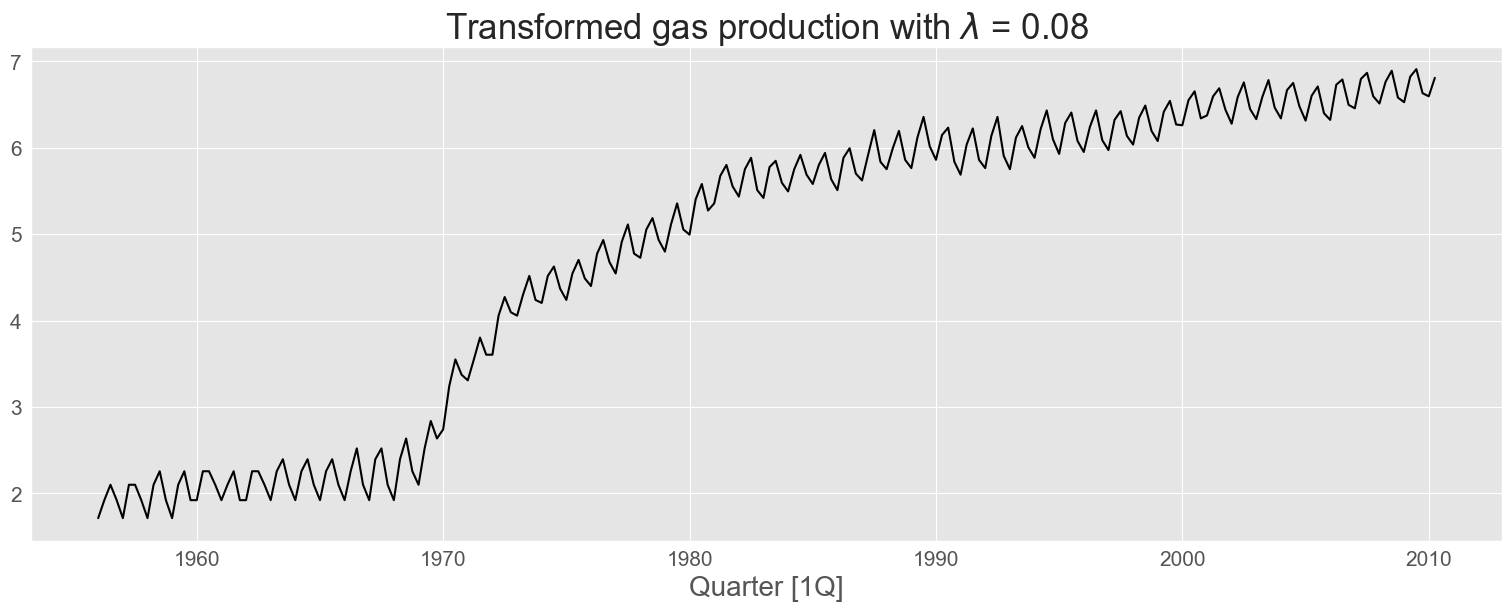

In [5]:
aus_production = pd.read_csv("./data/aus_production.csv",
    parse_dates=["ds"])
aus_gas = (
    aus_production[["ds", "Gas"]]
    .rename(columns={"Gas": "y"})
    .assign(unique_id="Gas")
)

y = aus_gas["y"].to_numpy()
optim_lambda = boxcox_lambda(y, method="guerrero", season_length=4)
df = aus_gas.assign(y_transformed=boxcox(y, optim_lambda))

title = rf"Transformed gas production with $\lambda$ = {optim_lambda:.2f}"
plot_series(df, target_col="y_transformed",
    xlabel="Quarter [1Q]", ylabel="", title=title)

### 3.2 Time series components

Assuming an additive decomposition, we can write $$y_t = S_t + T_t + R_t,$$ where $y$ is the data, $S$ is the seasonal component, $T$ is the trend-cycle component, and $R$ is the remainder component. An additive decomposition is appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, doesn't vary with the level of the time series. If the variation in seasonal pattern or variation around the trend-cycle appears proportional to the level of the series, a multiplicative decomposition is more appropriate (common with economic time series). 

### Example: Employment in the US retail sector

As an example, let's decompose the number of people employed in US retail below. The data shows the total monthly number of people in thousands employed in retail across the US since 1990.

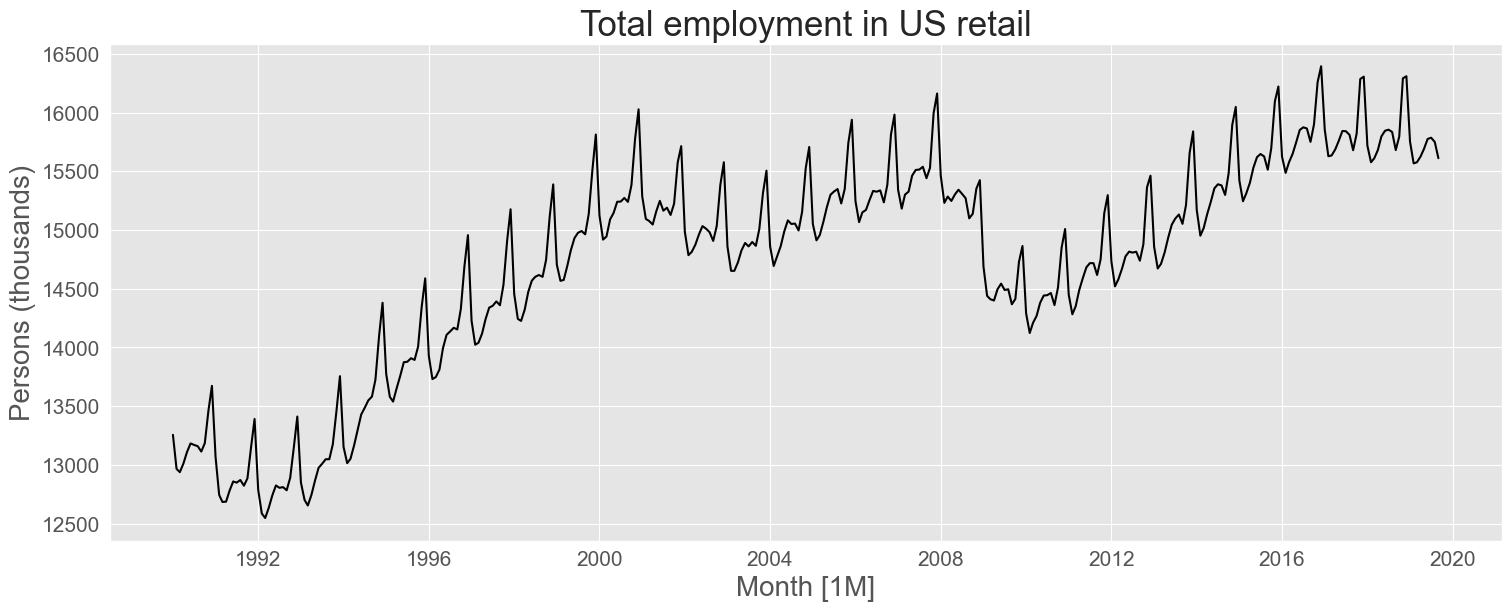

In [6]:
us_employment = pd.read_csv("./data/us_employment.csv", parse_dates=["ds"])
us_retail_employment = us_employment.loc[lambda x:
    (x["unique_id"] == "Retail Trade") & (x["ds"] >= "1990")
]

plot_series(us_retail_employment,
    xlabel="Month [1M]", ylabel="Persons (thousands)",
    title="Total employment in US retail")

We use the STL decomposition method, discussed in Section 3.6. 

In [7]:
stl = STL(us_retail_employment["y"], period=12)
res = stl.fit()

dcmp = pd.DataFrame({
    "ds": us_retail_employment["ds"],
    "data": us_retail_employment["y"],
    "trend": res.trend,
    "seasonal": res.seasonal,
    "remainder": res.resid,
}).reset_index(drop=True)

dcmp.head()

,ds,data,trend,seasonal,remainder
0,1990-01-01,13255.8,13296.249,-3.700,-36.749
1,1990-02-01,12966.3,13276.085,-288.398,-21.387
2,1990-03-01,12938.2,13255.663,-306.658,-10.805
3,1990-04-01,13012.3,13234.986,-235.775,13.089
4,1990-05-01,13108.3,13214.071,-115.399,9.628


The above dataframe shows the different estimated components of an STL decomposition. The `trend` column follows the overall movement of the series, ignoring seasonality and random fluctuations, as shown below. 

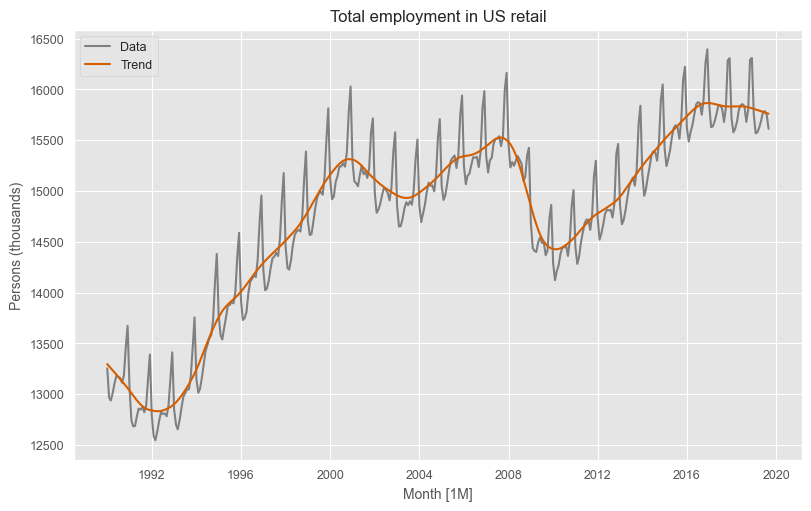

In [8]:
fig, ax = plt.subplots()
sns.lineplot(data=dcmp, x="ds", y="data", color="gray", label="Data")
sns.lineplot(data=dcmp, x="ds", y="trend", color="#D55E00", label="Trend")
ax.set(
    title="Total employment in US retail",
    xlabel="Month [1M]",
    ylabel="Persons (thousands)",
)
plt.show()

We can similarly plot all components of the decomposition as shown below.

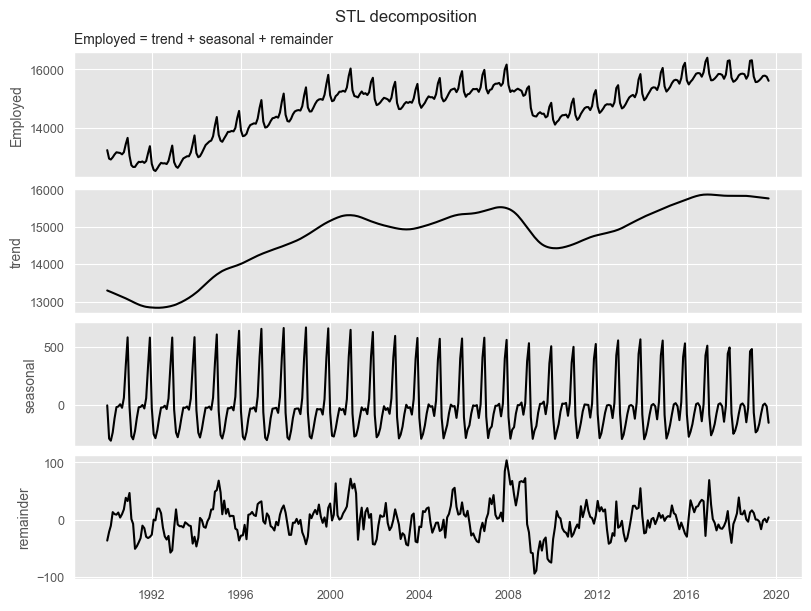

In [9]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
sns.lineplot(data=dcmp, x="ds", y="data", ax=axes[0])
sns.lineplot(data=dcmp, x="ds", y="trend", ax=axes[1])
sns.lineplot(data=dcmp, x="ds", y="seasonal", ax=axes[2])
sns.lineplot(data=dcmp, x="ds", y="remainder", ax=axes[3])
axes[0].set_title("Employed = trend + seasonal + remainder",
    size="medium", loc="left")
axes[0].set(ylabel="Employed")
axes[3].set(xlabel="")
fig.suptitle("STL decomposition")
plt.show()

Summing the three components in the bottom three panels produces the original time series in the top panel.

Note the change in the seasonal component over time.

### Seasonally adjusted data

If the seasonal component is removed, the resulting values are "seasonally adjusted". For an additive decomposition, the seasonally adjusted data is given by $$y_t - S_t.$$

Below shows the seasonally adjusted number of people employed. 

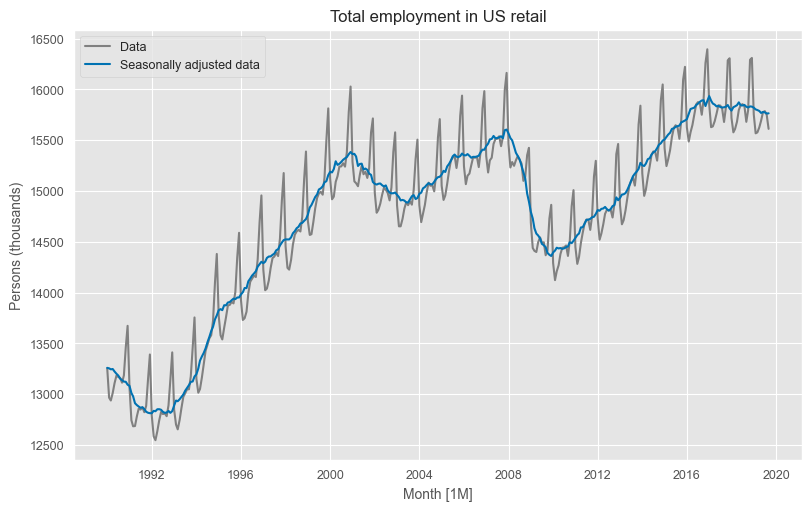

In [10]:
df = dcmp.assign(adj=lambda x: x["data"] - x["seasonal"])

fig, ax = plt.subplots()
sns.lineplot(data=df, x="ds", y="data",
    color="gray", label="Data")
sns.lineplot(data=df, x="ds", y="adj",
    color="#0072B2", label="Seasonally adjusted data")
ax.set(
    title="Total employment in US retail",
    xlabel="Month [1M]",
    ylabel="Persons (thousands)",
)
plt.show()

Employment data and many other economic series are usually seasonally adjusted since the seasonal variation is not of primary interest. 

### 3.3 Moving averages

The first step in a classical decomposition is to use a moving average method to estimate the trend cycle. 

### Moving average smoothing

A moving average of order $m$ can be written as $$ \hat{T}_t =\frac{1}{m}\sum_{j=-k}^{k} y_{t+j},$$ where $m=2k+1$. Thus the estimate of the trend cycle at time $t$ is obtained by averaging values of the time series that are within $k$ steps of $t$. 

Consider the below plot which show exports of goods and services for Australia as a percentage of GDP from 1960 to 2017. 

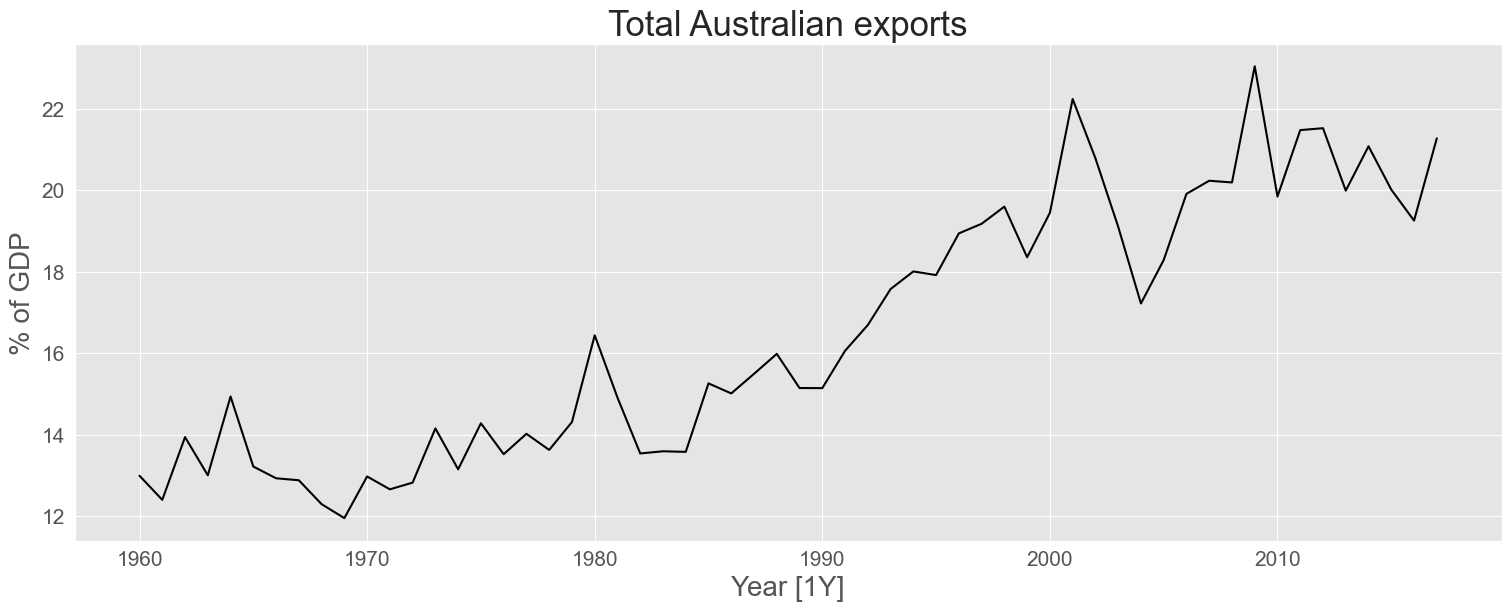

In [11]:
global_economy = pd.read_csv("./data/global_economy.csv")
df = global_economy.loc[lambda x: x["unique_id"] == "Australia"]

plot_series(df, target_col="Exports",
    xlabel="Year [1Y]", ylabel="% of GDP",
    title="Total Australian exports")

Let's look at the 5-year MA for this data. 

In [12]:
aus_exports = (
    global_economy
    .loc[lambda x: x["unique_id"] == "Australia"]
    .assign(MA_5=lambda x: x["Exports"].rolling(5, center=True).mean())
)

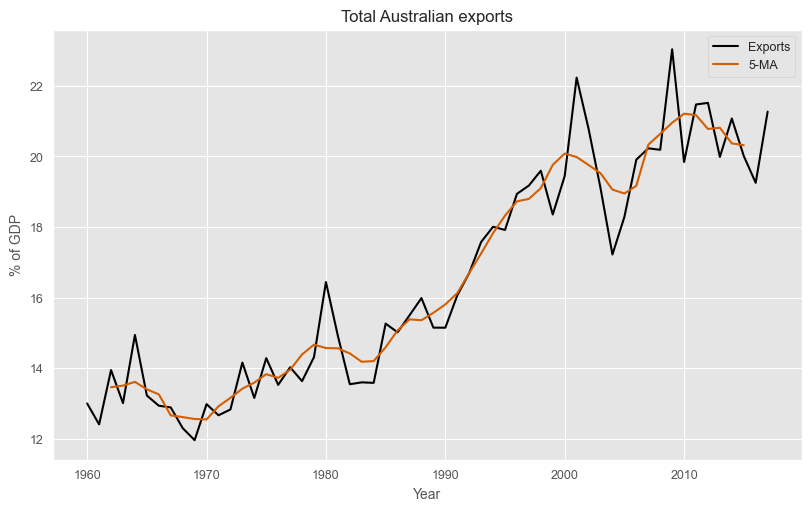

In [13]:
fig, ax = plt.subplots()
sns.lineplot(data=aus_exports, x="ds", y="Exports",
    color="black", label="Exports")
sns.lineplot(data=aus_exports, x="ds", y="MA_5",
    color="#D55E00", label="5-MA")
ax.set(
    title="Total Australian exports",
    xlabel="Year",
    ylabel="% of GDP",
)
plt.show()

### Moving averages of moving averages

We might take a moving average of order 4, then apply another moving average of order 2 to that. In the following, we do this for the first few years of the Australian quarterly beer production data. 

In [14]:
aus_production = pd.read_csv("./data/aus_production.csv",
    parse_dates=["ds"])
beer = (
    aus_production[["ds", "Beer"]]
    .loc[lambda x: x["ds"] >= "1992"]
    .reset_index(drop=True)
)
beer["4-MA"] = beer["Beer"].rolling(4, center=True).mean().shift(-1)
beer["2x4-MA"] = beer["4-MA"].rolling(2, center=True).mean()

In [15]:
beer.head(10)

,ds,Beer,4-MA,2x4-MA
0,1992-01-01,443,NaN,NaN
1,1992-04-01,410,451.25,NaN
2,1992-07-01,420,448.75,450.000
3,1992-10-01,532,451.50,450.125
4,1993-01-01,433,449.00,450.250
5,1993-04-01,421,444.00,446.500
6,1993-07-01,410,448.00,446.000
7,1993-10-01,512,438.00,443.000
8,1994-01-01,449,441.25,439.625
9,1994-04-01,381,446.00,443.625


The notation "2x4-MA" means a 4-MA followed by a 2-MA. When a 2-MA follows a moving average of even order, it's called a "centered moving average of order 4", since the results are now symmetric. In general, an even order MA should be followed by an even order MA to make it symmetric about each $y_t$, and similarly for odd. 

### Estimating the trend cycle with seasonal data

The most common use of centered moving averages is for estimating the trend-cycle from seasonal data. 

Consider the 2x4-MA:
$$
\begin{aligned}
    \hat{T}_t &= \frac{1}{2}\left(\frac{1}{4}(y_{t-2} + y_{t-1} + y_t + y_{t+1}) +  \frac{1}{4}(y_{t-1} + y_{t} + y_{t+1} + y_{t+2})\right)\\
    &= \frac{1}{8}y_{t-2} + \frac{1}{4}y_{t-1} + \frac{1}{4}y_{t} + \frac{1}{4}y_{t+1} + \frac{1}{8}y_{t+2}
\end{aligned}
$$

When applied to quarterly data, each quarter is given equal weight of 1/4 since the first and last terms apply to the same quarter in consecutive years. Thus the seasonal variation will be averaged out. A similar effect would be obtained using a 2x4k-MA to quarterly data. 

In general, a 2xm-MA is equivalent to a weighted moving average of order $m+1$ where all observations take the weight 1/m except the first and last which take weights 1/2m. If the seasonal period is even of order $m$, we use a 2xm-mA to estimate the trend cycle. If the seasonal period is odd of order $m$, use an m-MA to estimate it. 

Other choices for the order of the MA usually result in trend-cycle estimates being contaminated by seasonality. 

### Example: Employment in the US retail sector

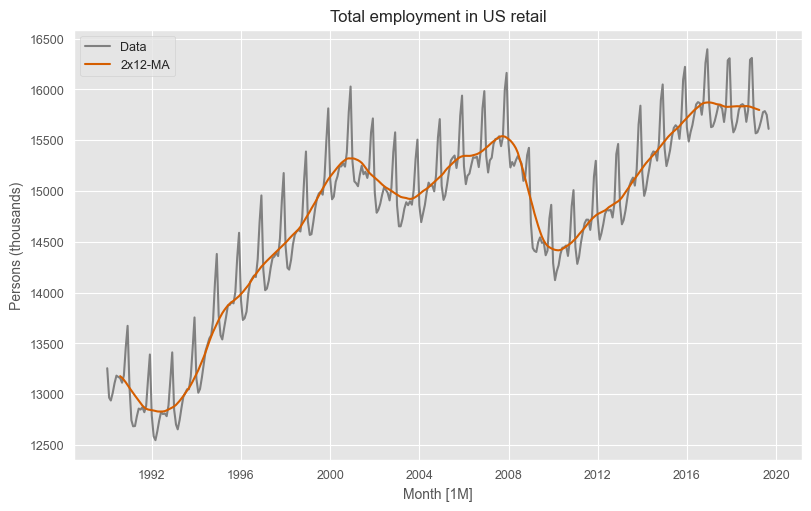

In [16]:
df = us_retail_employment.copy()
df["12-MA"] = df["y"].rolling(window=12, center=True).mean()
df["2x12-MA"] = df["12-MA"].rolling(window=2, center=True).mean()

fig, ax = plt.subplots()
sns.lineplot(data=df, x="ds", y="y",
    color="grey", label="Data")
sns.lineplot(data=df, x="ds", y="2x12-MA",
    color="#D55E00", label="2x12-MA")
ax.set(
    title="Total employment in US retail",
    xlabel="Month [1M]",
    ylabel="Persons (thousands)",
)
plt.show()

The above plot uses a 2x12-MA applied to monthly employment in US retail. The smooth line has no seasonality, and is almost the same as the trend-cycle shown above that was estimated using a more sophisticated decomposition technique (STL) than a moving average. Any other choice of order (except for multiples of 12) would have shown some seasonality. 

### Weighted moving averages

The 2x4-MA shown above is equivalent to a weighted 5-MA with weights 1/8, 1/4, 1/4, 1/4, 1/8.

It's important that the weights sum to 1 and that they're symmetric. The simple $m$-MA is a special case where all the weights equal 1/m. 

A major advantage of weighted MAs is that they yield a smoother estimate of the trend-cycle if the weights are smaller at the ends. 

## 3.4 Classical decomposition

Two forms
- additive decomposition
- multiplicative decomposition
These are described below for a series with seasonal period $m$ ($m=4$ for quarterly data, $m=12$ for monthly data, $m=7$ for daily data with a weekly pattern).

Assume that the seasonal component is constant from year to year. 

### Additive decomposition

1. If $m$ is even, compute the trend-cycle component $\hat{T}_t$ using a $2\times m$-MA. If $m$ is odd, compute it using an $m$-MA.
2. Calculate the detrended series $y_t - \hat{T}_t$.
3. To estimate the seasonal component for each season, average the detrended values for that season. E.g. for monthly data, the seasonal component for March is the average of all detrended March values in the data. The seasonal component values are adjusted to ensure they add to zero. The seasonal component is obtained by stringing together these values then replicating the sequence for each year of data, giving $\hat{S}_t$.
4. Calculate the remainder by subtracting the trend and the seasonal: $\hat{R}_t = y_t - \hat{T}_t - \hat{S}_t$. 

### Multiplicative decomposition

1. 1. If $m$ is even, compute the trend-cycle component $\hat{T}_t$ using a $2\times m$-MA. If $m$ is odd, compute it using an $m$-MA.
2. Calculate the detrended series $y_t / \hat{T}_t$.
3. To estimate the seasonal component for each season, average the detrended values for that season. E.g. for monthly data, the seasonal component for March is the average of all detrended March values in the data. The seasonal component values are adjusted to ensure they add to $m$. The seasonal component is obtained by stringing together these values then replicating the sequence for each year of data, giving $\hat{S}_t$.
4. Calculate the remainder by dviding out the trend and the seasonal: $\hat{R}_t = y_t /(\hat{T}_t \hat{S}_t)$. 

### Comments on classical decomposition

Not typically recommended as there are better methods. Some problems with classical decomp:
- The estimate of trend-cycle is unavailable for the first few and last few observations, therefore no estimate of the seasonal or remainder either
- The trend-cycle estimate tends to over-smooth rapid rises and falls in the data
- Assumes that the seasonal component does not change from year to year, which is not reasonable for some series e.g. electricity demand over time as A/C has become more widespread. 
- The classical method is not robust to values from unusual events, e.g. monthly air traiffic affected by a temporary industrial dispute leading to outlier values. 

## 3.5 Methods used by official statistics agencies

The following methods are used for seasonal adjustment and are specifically designed to work with quarterly and monthly data. They won't handle seasonality of other kinds, like daily, hourly, weekly, etc. 

### X-11 method

Based on classical decomposition, but trend-cycle estimates are available for all observations including the end points, and the seasonal component is allowed to vary slowly over time. It also handles trading day variation, holiday effects, and the effects of known predictors. Process is automatic, and is robust to outliers/level shifts in the series. 

### SEATS method

"Seasonal Extraction in ARIMA Time Series"

## 3.6 STL decomposition

- Stands for "Seasonal and Trend decomposition using Loess" (loess is a method for estimating nonlinear relationships)
- versatile and robust
- handles any type of seasonality
- seasonal component can change over time at a rate controlled by the user
- smoothness of the trend-cycle can be controlled by the user
- can be robust to outliers 
- Disadvantages: doesn't handle trading day or calendar variation automatically, and only facilitates additive decompositions

However, a multiplicative decomposition can be obtained by first taking logs of the data, then back-transforming the components. Decompositions between additive and multiplicative can be obtained using a Box-Cox transformation with $0 < \lambda < 1$, where $\lambda = 0$ gives a multiplicative decomp and $\lambda=1$ gives an additive decomp. 

Below we see an example of an STL decomp applied to the total US retail employment series, where the trend-cycle is flexible, the seasonal pattern is fixed, and the robust option has been used.

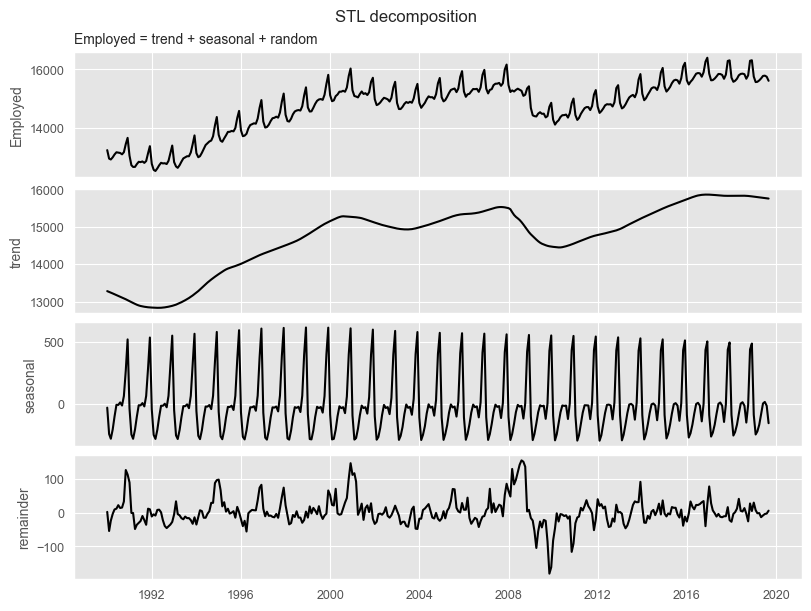

In [17]:
stl = STL(us_retail_employment["y"], period=12,
    seasonal=13, trend=21, robust=True)
res_stl = stl.fit()
dcmp = pd.DataFrame({
    "ds": us_retail_employment["ds"],
    "data": us_retail_employment["y"],
    "trend": res_stl.trend,
    "seasonal": res_stl.seasonal,
    "remainder": res_stl.resid,
}).reset_index(drop=True)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
sns.lineplot(data=dcmp, x="ds", y="data", ax=axes[0])
sns.lineplot(data=dcmp, x="ds", y="trend", ax=axes[1])
sns.lineplot(data=dcmp, x="ds", y="seasonal", ax=axes[2])
sns.lineplot(data=dcmp, x="ds", y="remainder", ax=axes[3])
axes[0].set_title("Employed = trend + seasonal + random",
    size="medium", loc="left")
axes[0].set(ylabel="Employed")
axes[3].set(xlabel="")
fig.suptitle("STL decomposition")
plt.show()

The two main parameters in STL are `season` (length of the seasonal smoother) and `trend` (length of the trend smoother). Both trend and seasonal windows should be odd numbers. 

## 3.7 Exercises

### 1
Consider the GDP information in global_economy. Plot the GDP per capita for each country over time. Which country has the highest GDP per capita? How has this changed over time?

### 1 Solution

In [18]:
global_economy = pd.read_csv("./data/global_economy.csv")
global_economy.head()

,unique_id,Code,ds,GDP,Growth,CPI,Imports,Exports,Population
0,Afghanistan,AFG,1960,5.378e+08,NaN,NaN,7.025,4.132,8.996e+06
1,Afghanistan,AFG,1961,5.489e+08,NaN,NaN,8.097,4.453,9.167e+06
2,Afghanistan,AFG,1962,5.467e+08,NaN,NaN,9.350,4.878,9.346e+06
3,Afghanistan,AFG,1963,7.511e+08,NaN,NaN,16.864,9.172,9.534e+06
4,Afghanistan,AFG,1964,8.000e+08,NaN,NaN,18.056,8.889,9.731e+06


In [19]:
countries = global_economy["unique_id"].unique()
print(countries)

<StringArray>
[          'Afghanistan',               'Albania',               'Algeria',
        'American Samoa',               'Andorra',                'Angola',
   'Antigua and Barbuda',            'Arab World',             'Argentina',
               'Armenia',
 ...
            'Uzbekistan',               'Vanuatu',         'Venezuela, RB',
               'Vietnam', 'Virgin Islands (U.S.)',    'West Bank and Gaza',
                 'World',           'Yemen, Rep.',                'Zambia',
              'Zimbabwe']
Length: 263, dtype: str


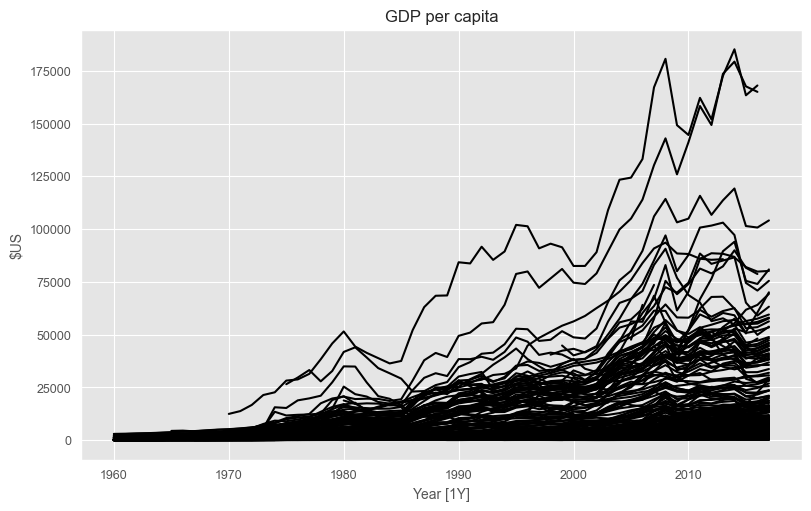

In [20]:
global_economy['GDP_per_capita'] = global_economy["GDP"] / global_economy["Population"] 
for country in countries:
    country_gdp_per_capita = global_economy.loc[lambda x: x["unique_id"] == country, ["ds", "GDP_per_capita"]]
    plt.plot(country_gdp_per_capita["ds"], country_gdp_per_capita["GDP_per_capita"], label=country)
plt.xlabel("Year [1Y]")
plt.ylabel("$US")
plt.title("GDP per capita")
plt.show()
    

In [21]:
years = global_economy["ds"].unique()
print(years)

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]


In [22]:
highest_gdp_per_capita = pd.DataFrame(columns=["ds", "unique_id", "GDP_per_capita"])
for year in years:
    row = global_economy.loc[lambda x: x["ds"] == year, ["ds", "unique_id", "GDP_per_capita"]].sort_values("GDP_per_capita", ascending=False).iloc[0]
    highest_gdp_per_capita = pd.concat([highest_gdp_per_capita, row.to_frame().T], ignore_index=True)

print(highest_gdp_per_capita)


      ds             unique_id GDP_per_capita
0   1960         United States       3007.123
1   1961         United States       3066.563
2   1962         United States       3243.843
3   1963         United States       3374.515
4   1964         United States       3573.941
5   1965                Kuwait       4429.171
6   1966                Kuwait       4556.463
7   1967         United States       4336.427
8   1968         United States       4695.923
9   1969         United States       5032.145
10  1970                Monaco      12479.725
11  1971                Monaco      13813.301
12  1972                Monaco      16733.622
13  1973                Monaco      21422.841
14  1974                Monaco      22707.456
15  1975                Monaco      28254.276
16  1976  United Arab Emirates      29698.169
17  1977  United Arab Emirates      33245.836
18  1978                Monaco      38353.806
19  1979                Monaco      45838.162
20  1980                Monaco    

/var/folders/sz/kx_yftld6rs9z42kwpsm47y40000gn/T/ipykernel_56449/3682318967.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


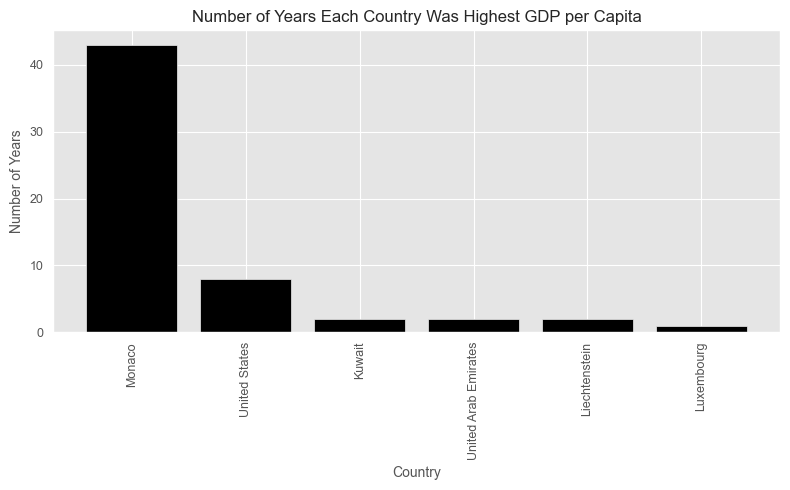

In [23]:
year_counts = highest_gdp_per_capita["unique_id"].value_counts()
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Country")
plt.ylabel("Number of Years")
plt.title("Number of Years Each Country Was Highest GDP per Capita")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Clearly, the country that has had the highest GDP per capita *most frequently* over the years is Monaco, and it dominated the list continuously from 1978-2012. In recent years, Lichtenstein and Luxembourg have entered the top rankings. 

### 2 

For each of the following series, make a graph of the data. If transforming seems appropriate, do so and describe the effect.

- United States GDP from `global_economy`.
- Slaughter of Victorian “Bulls, bullocks and steers” in `aus_livestock`.
- Victorian Electricity Demand from `vic_elec`.
- Gas production from `aus_production`.

### 2 Solution

#### US GDP from `global_economy`

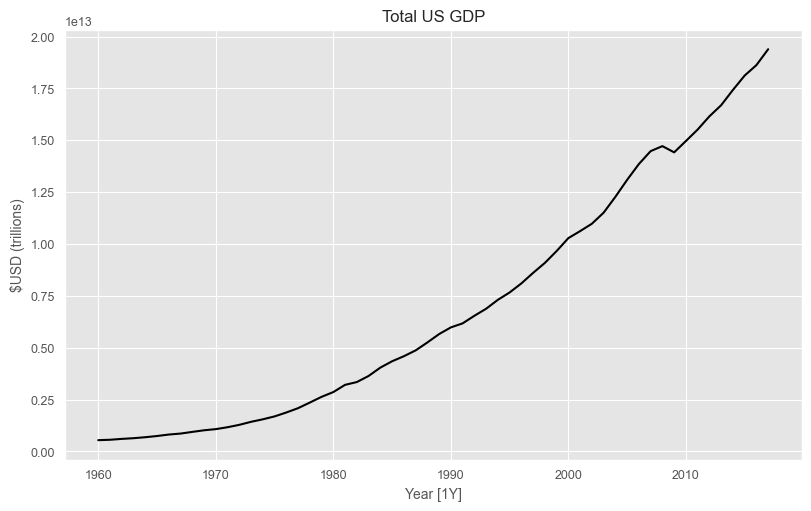

In [24]:
global_economy = pd.read_csv("./data/global_economy.csv")
US_GDP = global_economy.loc[lambda x: x['unique_id'] == 'United States', ['ds', 'GDP']]
plt.plot(US_GDP["ds"], US_GDP["GDP"], color="black")
plt.xlabel("Year [1Y]")
plt.ylabel("$USD (trillions)")
plt.title("Total US GDP")
plt.show()

Adjusting GDP numbers by population seems appropriate. 

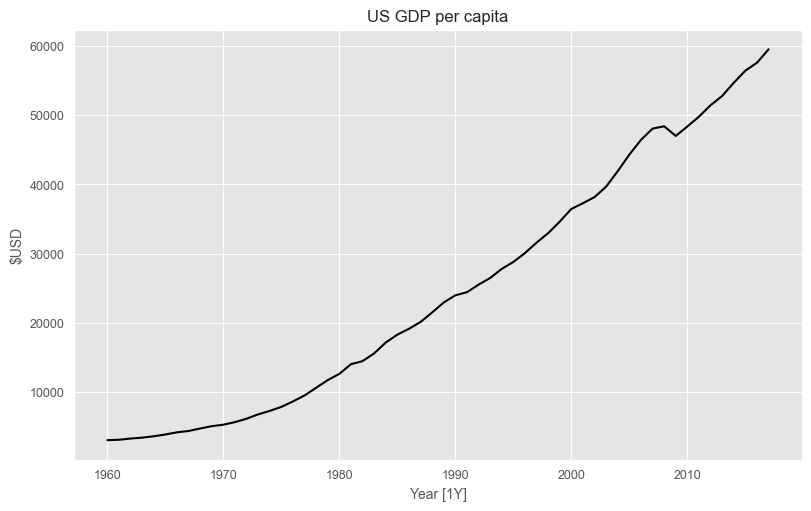

In [25]:
US_pop = global_economy.loc[lambda x: x['unique_id'] == 'United States', ['ds', 'Population']]
US_GDP_adjusted = US_GDP.copy()
US_GDP_adjusted["GDP_per_capita"] = US_GDP_adjusted["GDP"] / US_pop["Population"]

plt.plot(US_GDP_adjusted["ds"], US_GDP_adjusted["GDP_per_capita"], color="black")
plt.xlabel("Year [1Y]")
plt.ylabel("$USD")
plt.title("US GDP per capita")
plt.show()

#### Slaughter of Victorian “Bulls, bullocks and steers” in `aus_livestock`

In [26]:
aus_livestock = pd.read_csv("./data/aus_livestock.csv", parse_dates=["ds"])
aus_livestock.head()

,unique_id,ds,y
0,"Australian Capital Territory_Bulls, bullocks and steers",1976-07-01,2300.0
1,"Australian Capital Territory_Bulls, bullocks and steers",1976-08-01,2100.0
2,"Australian Capital Territory_Bulls, bullocks and steers",1976-09-01,2100.0
3,"Australian Capital Territory_Bulls, bullocks and steers",1976-10-01,1900.0
4,"Australian Capital Territory_Bulls, bullocks and steers",1976-11-01,2100.0


In [27]:
type(aus_livestock["ds"].iloc[0])

pandas.Timestamp

In [28]:
aus_livestock.set_index("ds", inplace=True)
aus_livestock.head()

,unique_id,y
ds,,
1976-07-01,"Australian Capital Territory_Bulls, bullocks and steers",2300.0
1976-08-01,"Australian Capital Territory_Bulls, bullocks and steers",2100.0
1976-09-01,"Australian Capital Territory_Bulls, bullocks and steers",2100.0
1976-10-01,"Australian Capital Territory_Bulls, bullocks and steers",1900.0
1976-11-01,"Australian Capital Territory_Bulls, bullocks and steers",2100.0


In [29]:
aus_livestock['unique_id'].unique()

<StringArray>
['Australian Capital Territory_Bulls, bullocks and steers',
              'New South Wales_Bulls, bullocks and steers',
           'Northern Territory_Bulls, bullocks and steers',
                   'Queensland_Bulls, bullocks and steers',
              'South Australia_Bulls, bullocks and steers',
                     'Tasmania_Bulls, bullocks and steers',
                     'Victoria_Bulls, bullocks and steers',
            'Western Australia_Bulls, bullocks and steers',
                     'Australian Capital Territory_Calves',
                                  'New South Wales_Calves',
                               'Northern Territory_Calves',
                                       'Queensland_Calves',
                                  'South Australia_Calves',
                                         'Tasmania_Calves',
                                         'Victoria_Calves',
                                'Western Australia_Calves',
      'Australian Capital 

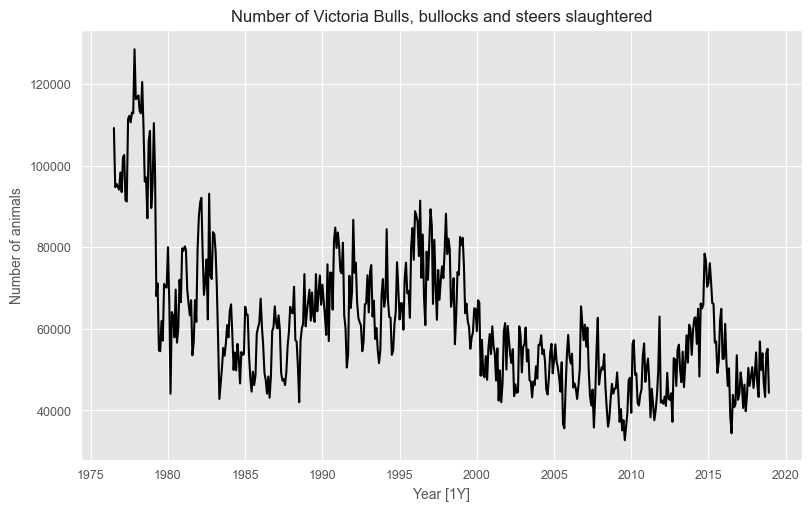

In [30]:
victoria_bbs_id = 'Victoria_Bulls, bullocks and steers'
victoria_bbs_df = aus_livestock.loc[lambda x: x['unique_id'] == victoria_bbs_id, ['y']]

plt.plot(victoria_bbs_df.index, victoria_bbs_df["y"])
plt.xlabel("Year [1Y]")
plt.ylabel("Number of animals")
plt.title("Number of Victoria Bulls, bullocks and steers slaughtered")
plt.show()

Since this is monthly data, it seems appropriate to adjust the data for calendar effects by normalizing the counts by the number of days per month. 

In [31]:
victoria_bbs_df['days_in_month'] = victoria_bbs_df.index.days_in_month
victoria_bbs_df['days_in_month'].head()

ds
1976-07-01    31
1976-08-01    31
1976-09-01    30
1976-10-01    31
1976-11-01    30
Name: days_in_month, dtype: int32

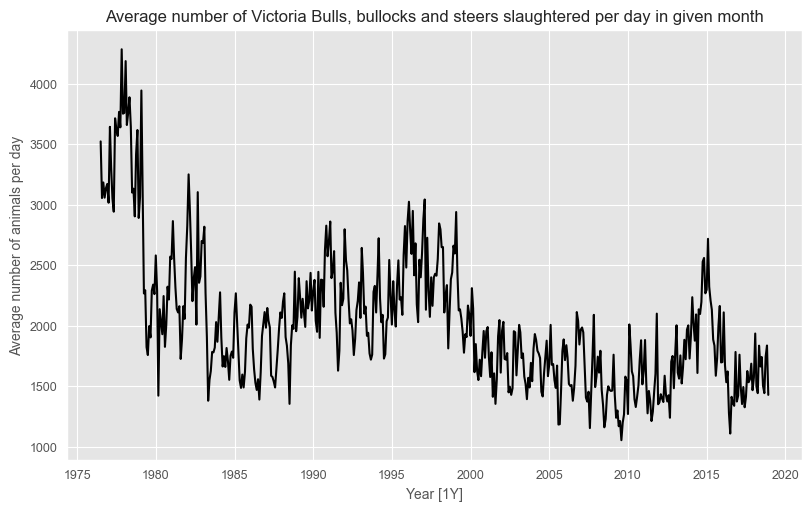

In [32]:
victoria_bbs_df['y_per_day'] = victoria_bbs_df['y'] / victoria_bbs_df['days_in_month']
plt.plot(victoria_bbs_df.index, victoria_bbs_df["y_per_day"])
plt.xlabel("Year [1Y]")
plt.ylabel("Average number of animals per day")
plt.title("Average number of Victoria Bulls, bullocks and steers slaughtered per day in given month")
plt.show()

#### Victorian Electricity Demand

In [33]:
vic_elec = pd.read_csv("./data/vic_elec.csv", parse_dates=["ds"])
vic_elec.set_index("ds", inplace=True)
vic_elec.head()

,unique_id,y,Holiday
ds,,,
2012-01-01 00:00:00,Demand,4382.825,True
2012-01-01 00:30:00,Demand,4263.366,True
2012-01-01 01:00:00,Demand,4048.966,True
2012-01-01 01:30:00,Demand,3877.563,True
2012-01-01 02:00:00,Demand,4036.230,True


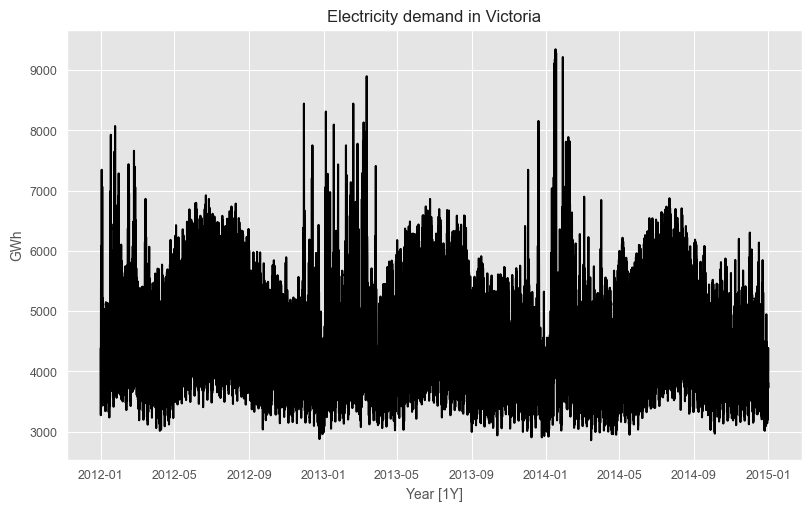

In [34]:
vic_elec_demand = vic_elec.loc[lambda x: x["unique_id"] == "Demand", ["y"]]
plt.plot(vic_elec_demand.index, vic_elec_demand["y"])
plt.xlabel("Year [1Y]")
plt.ylabel("GWh")
plt.title("Electricity demand in Victoria")
plt.show()

### 3

Why is a Box-Cox transformation unhelpful for the `canadian_gas` data?

### 3 Solution

In [35]:
canadian_gas = pd.read_csv("./data/canadian_gas.csv", parse_dates=["ds"])
canadian_gas.head()

,unique_id,ds,y
0,Canadian gas production,1960-01-01,1.431
1,Canadian gas production,1960-02-01,1.306
2,Canadian gas production,1960-03-01,1.402
3,Canadian gas production,1960-04-01,1.170
4,Canadian gas production,1960-05-01,1.116


In [36]:
canadian_gas.set_index("ds", inplace=True)
canadian_gas.head()

,unique_id,y
ds,,
1960-01-01,Canadian gas production,1.431
1960-02-01,Canadian gas production,1.306
1960-03-01,Canadian gas production,1.402
1960-04-01,Canadian gas production,1.170
1960-05-01,Canadian gas production,1.116


In [37]:
canadian_gas['unique_id'].unique()

<StringArray>
['Canadian gas production']
Length: 1, dtype: str

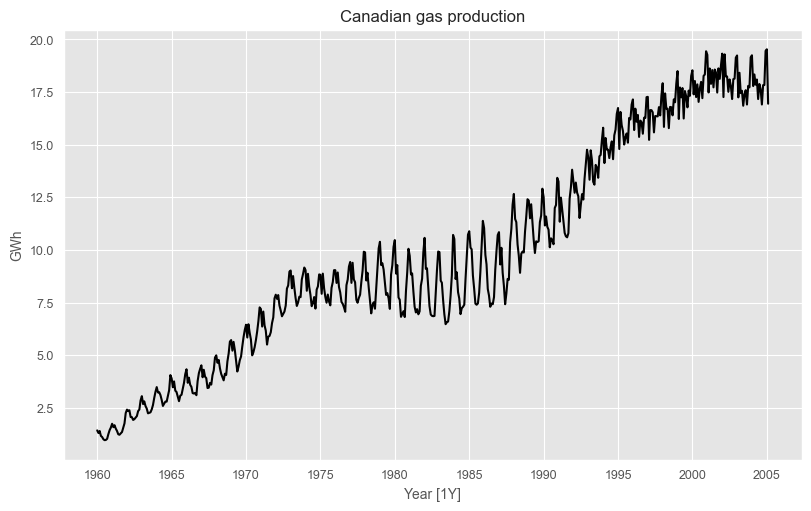

In [38]:
plt.plot(canadian_gas.index, canadian_gas["y"])
plt.xlabel("Year [1Y]")
plt.ylabel("GWh")
plt.title("Canadian gas production")
plt.show()

Per the plot, the seasonal variance in the data does not change much, either across time or across the level of the series. Since this seasonal variation is close to constant, a Box-Cox transformation is not likely to be helpful. 

### 4

What Box-Cox transformation would you select for your retail data (from Exercise 7 in Section 2.10)?

### 4 Solution

Select one of the time series from `aus_retail`:

In [39]:
aus_retail = pd.read_csv("./data/aus_retail.csv", parse_dates=["Month"])

np.random.seed(123)
random_series_id = np.random.choice(aus_retail['Series ID'].unique(), 1)[0]
myseries = aus_retail.query('`Series ID` == @random_series_id')
myseries.head()

,State,Industry,Series ID,Month,Turnover
45569,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-04-01,4.0
45570,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-05-01,4.0
45571,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-06-01,3.9
45572,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-07-01,4.4
45573,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-08-01,4.2


In [40]:
myseries.shape

(441, 5)

In [41]:
myseries.set_index("Month", inplace=True)
myseries.head()

,State,Industry,Series ID,Turnover
Month,,,,
1982-04-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,4.0
1982-05-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,4.0
1982-06-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,3.9
1982-07-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,4.4
1982-08-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,4.2


In [43]:
state = myseries['State'].unique()[0]
state

'Tasmania'

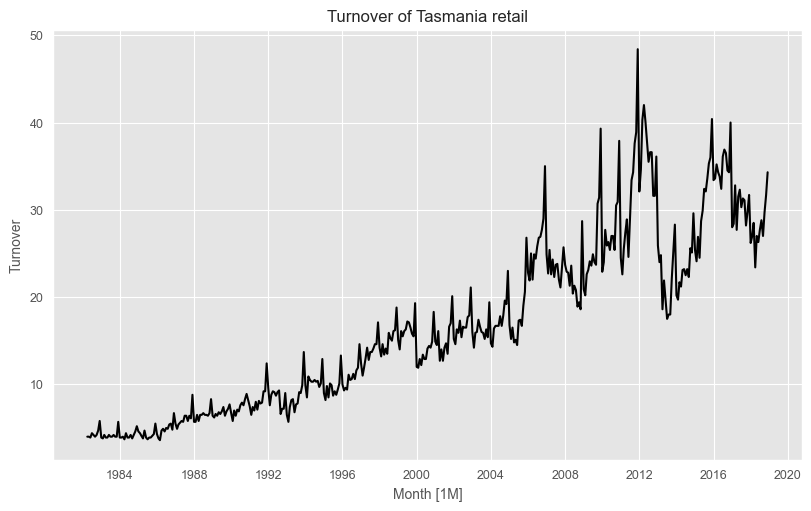

In [44]:
plt.plot(myseries.index, myseries["Turnover"])
plt.xlabel("Month [1M]")
plt.ylabel("Turnover")
plt.title(f"Turnover of {state} retail")
plt.show()

To determine a good value of $\lambda$ for the Box-Cox transformation, we'll use `boxcox_lambda()` from `CoreForecast`. 

Based on Exercise 7 in Ch. 2, we determined that this series has a seasonal period of $m=12$ months. We'll use this as an input into `boxcox_lambda`. 

In [45]:
optimal_lambda = boxcox_lambda(myseries["Turnover"], method="guerrero", season_length=12)
optimal_lambda

-0.8923776149749756

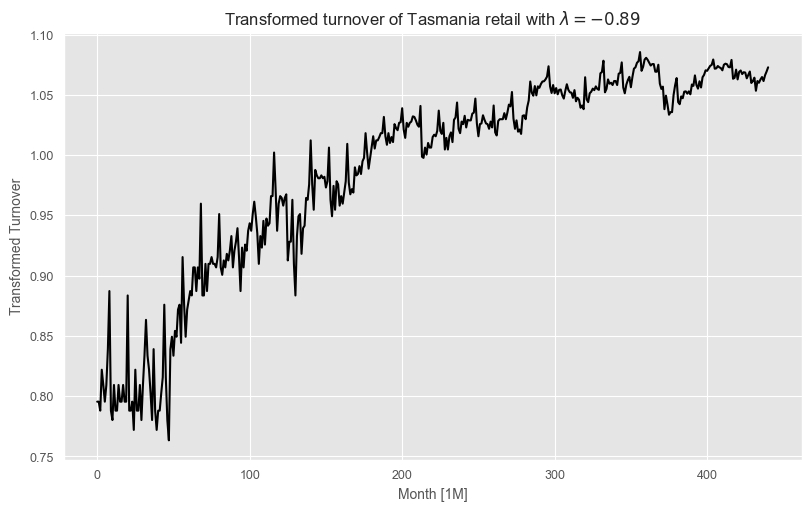

In [48]:
myseries_transformed = boxcox(myseries["Turnover"], optimal_lambda)
plt.plot(myseries_transformed)
plt.xlabel("Month [1M]")
plt.ylabel("Transformed Turnover")
plt.title(rf"Transformed turnover of {state} retail with $\lambda={optimal_lambda:.2f}$")
plt.show()

### 5

For the following series, find an appropriate Box-Cox transformation in order to stabilise the variance. Tobacco from `aus_production`, Economy class passengers between Melbourne and Sydney from `ansett`, and Pedestrian counts at Southern Cross Station from `pedestrian`.

### 5 Solutions

**Tobacco from `aus_production`**

In [52]:
aus_production = pd.read_csv("./data/aus_production.csv", parse_dates=["ds"])
aus_production.head()

,ds,Beer,Tobacco,Bricks,Cement,Electricity,Gas
0,1956-01-01,284,5225.0,189.0,465,3923,5
1,1956-04-01,213,5178.0,204.0,532,4436,6
2,1956-07-01,227,5297.0,208.0,561,4806,7
3,1956-10-01,308,5681.0,197.0,570,4418,6
4,1957-01-01,262,5577.0,187.0,529,4339,5


In [53]:
aus_production.set_index("ds", inplace=True)
aus_production.head()

,Beer,Tobacco,Bricks,Cement,Electricity,Gas
ds,,,,,,
1956-01-01,284,5225.0,189.0,465,3923,5
1956-04-01,213,5178.0,204.0,532,4436,6
1956-07-01,227,5297.0,208.0,561,4806,7
1956-10-01,308,5681.0,197.0,570,4418,6
1957-01-01,262,5577.0,187.0,529,4339,5


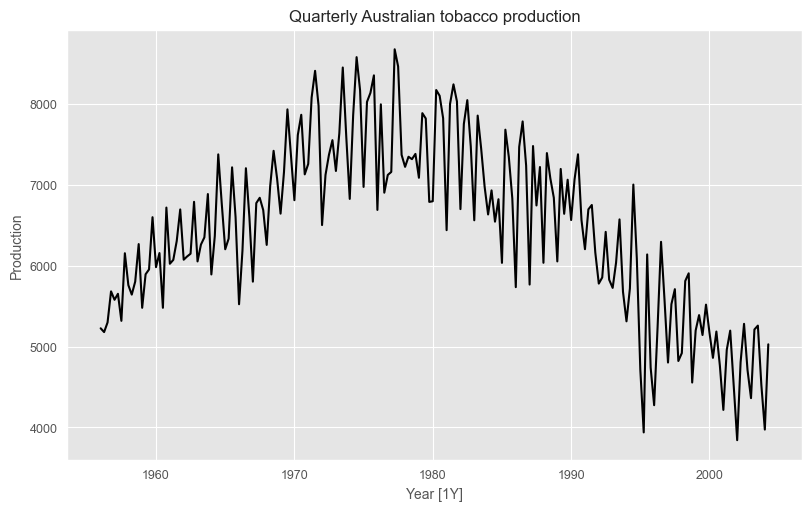

In [54]:
tobacco = aus_production['Tobacco']
plt.plot(tobacco)
plt.xlabel("Year [1Y]")
plt.ylabel("Production")
plt.title("Quarterly Australian tobacco production")
plt.show()

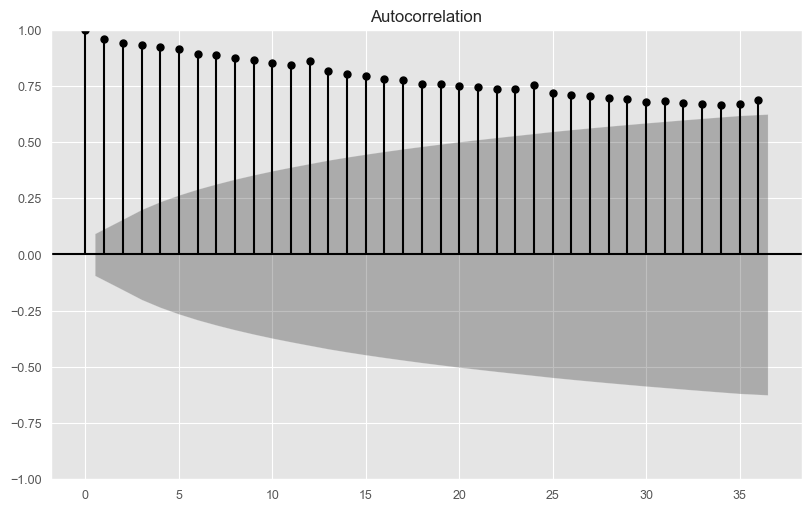

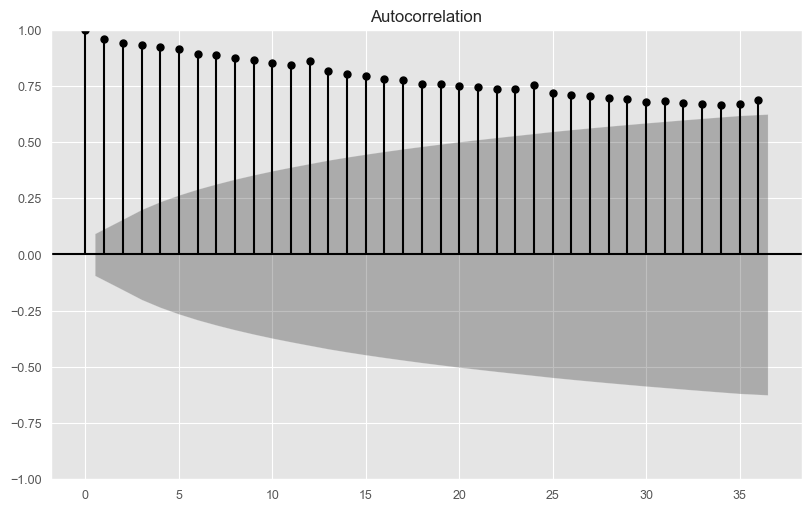

In [57]:
plot_acf(myseries["Turnover"], lags=36)

This indicates that we should choose $m=12$ as our seasonal period. 

In [58]:
optim_lambda_tobacco = boxcox_lambda(tobacco, method="guerrero", season_length=12)
optim_lambda_tobacco

0.2077014148235321

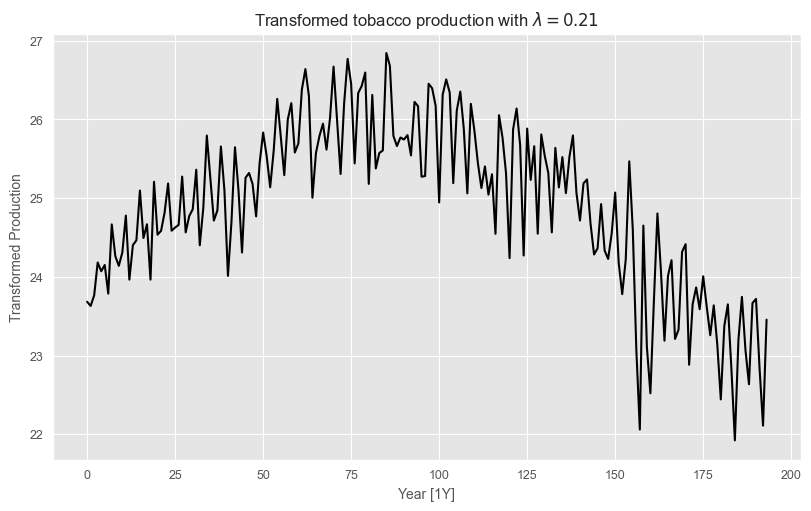

In [59]:
tobacco_transformed = boxcox(tobacco, optim_lambda_tobacco)
plt.plot(tobacco_transformed)
plt.xlabel("Year [1Y]")
plt.ylabel("Transformed Production")
plt.title(rf"Transformed tobacco production with $\lambda={optim_lambda_tobacco:.2f}$")
plt.show()

### 7

Consider the last five years of the Gas data from aus_production.
```python
gas = aus_production.loc[lambda x: x["unique_id"] == "Gas"].tail(5 * 4)
```
1. Plot the time series. Can you identify seasonal fluctuations and/or a trend-cycle?
2. Use seasonal_decompose with model='multiplicative' to calculate the trend-cycle and seasonal indices.
3. Do the results support the graphical interpretation from part a?
4. Compute and plot the seasonally adjusted data.
5. Change one observation to be an outlier (e.g., add 300 to one observation), and recompute the seasonally adjusted data. What is the effect of the outlier?
6. Does it make any difference if the outlier is near the end rather than in the middle of the time series?

### 7 Solution

In [63]:
aus_production = pd.read_csv("./data/aus_production.csv", parse_dates=["ds"])
aus_production.head()

,ds,Beer,Tobacco,Bricks,Cement,Electricity,Gas
0,1956-01-01,284,5225.0,189.0,465,3923,5
1,1956-04-01,213,5178.0,204.0,532,4436,6
2,1956-07-01,227,5297.0,208.0,561,4806,7
3,1956-10-01,308,5681.0,197.0,570,4418,6
4,1957-01-01,262,5577.0,187.0,529,4339,5


In [65]:
aus_production.set_index("ds", inplace=True)

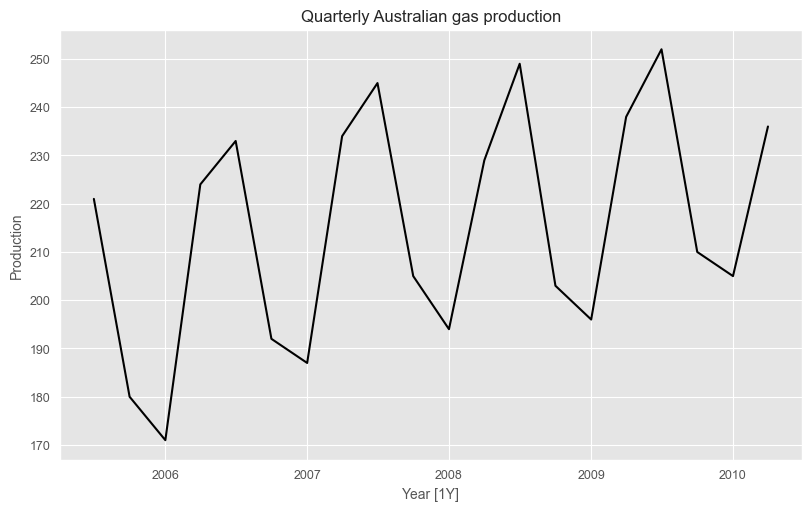

In [66]:
gas = aus_production["Gas"].tail(5 * 4)
plt.plot(gas)
plt.xlabel("Year [1Y]")
plt.ylabel("Production")
plt.title("Quarterly Australian gas production")
plt.show()

(a) In these last five years of Gas data, we can see clear seasonal fluctuations. Gas production peaks in the middle of the year (winter season) and falls in the beginning/end of the year (summer season). There is evidence of an upward trend, but the series is too short to see any cyclicality. 

(b)

/Users/david/dev/fpp/.venv/lib/python3.12/site-packages/statsmodels/tsa/seasonal.py:360: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


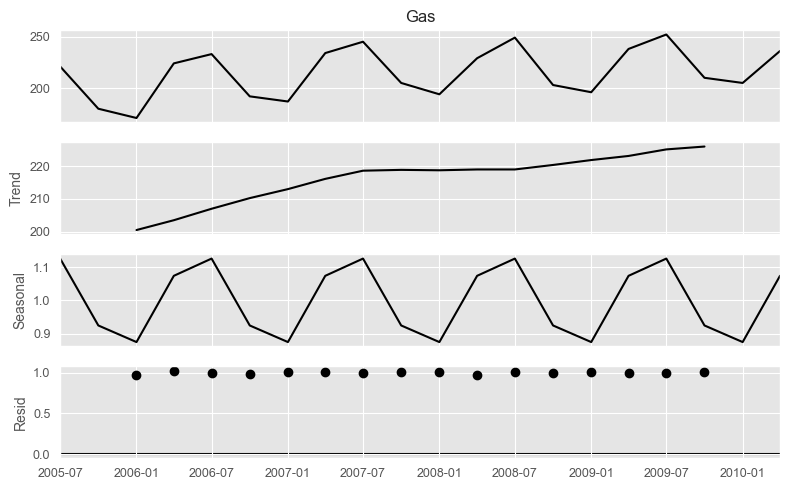

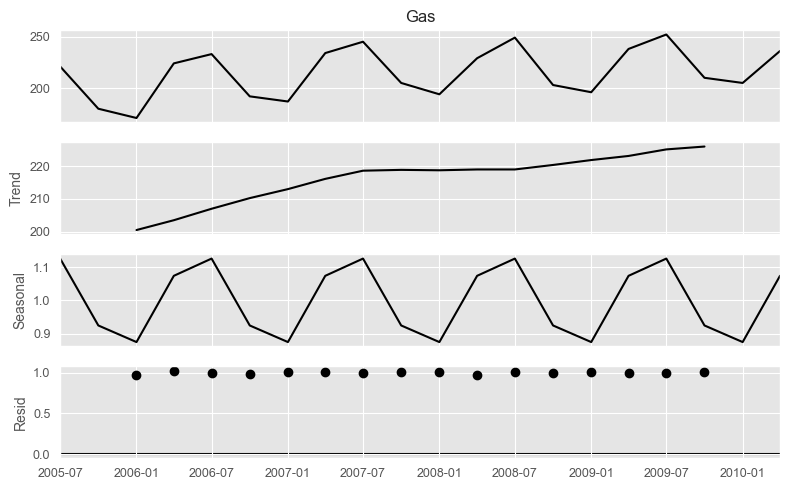

In [70]:
gas_seasonal_decopose = seasonal_decompose(gas, model="multiplicative")
gas_seasonal_decopose.plot()

(c) Yes, these results support the graphical interpretation from part (a).

(d)

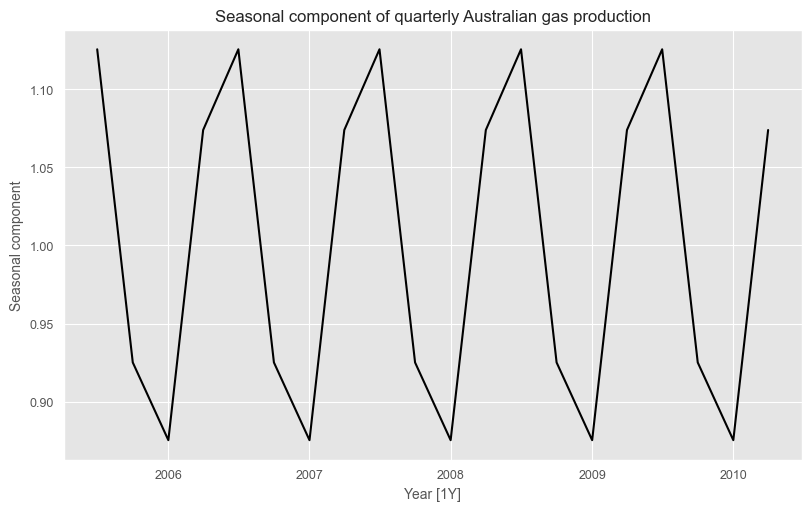

In [72]:
gas_seasonal = gas_seasonal_decopose.seasonal
plt.plot(gas_seasonal)
plt.xlabel("Year [1Y]")
plt.ylabel("Seasonal component")
plt.title("Seasonal component of quarterly Australian gas production")
plt.show()

(e)

In [75]:
gas_copy = gas.copy()
gas_copy

ds
2005-07-01    221
2005-10-01    180
2006-01-01    171
2006-04-01    224
2006-07-01    233
2006-10-01    192
2007-01-01    187
2007-04-01    234
2007-07-01    245
2007-10-01    205
2008-01-01    194
2008-04-01    229
2008-07-01    249
2008-10-01    203
2009-01-01    196
2009-04-01    238
2009-07-01    252
2009-10-01    210
2010-01-01    205
2010-04-01    236
Name: Gas, dtype: int64

In [76]:
rand_index = np.random.choice(gas_copy.index)
rand_index

np.datetime64('2006-01-01T00:00:00.000000')

In [77]:
gas_copy.loc[rand_index] += 300
gas_copy

ds
2005-07-01    221
2005-10-01    180
2006-01-01    471
2006-04-01    224
2006-07-01    233
2006-10-01    192
2007-01-01    187
2007-04-01    234
2007-07-01    245
2007-10-01    205
2008-01-01    194
2008-04-01    229
2008-07-01    249
2008-10-01    203
2009-01-01    196
2009-04-01    238
2009-07-01    252
2009-10-01    210
2010-01-01    205
2010-04-01    236
Name: Gas, dtype: int64

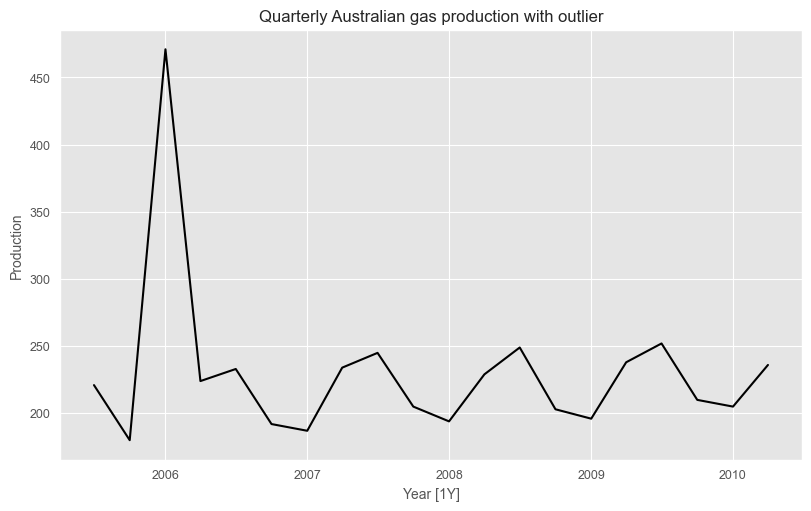

In [78]:
plt.plot(gas_copy)
plt.xlabel("Year [1Y]")
plt.ylabel("Production")
plt.title("Quarterly Australian gas production with outlier")
plt.show()

/Users/david/dev/fpp/.venv/lib/python3.12/site-packages/statsmodels/tsa/seasonal.py:360: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


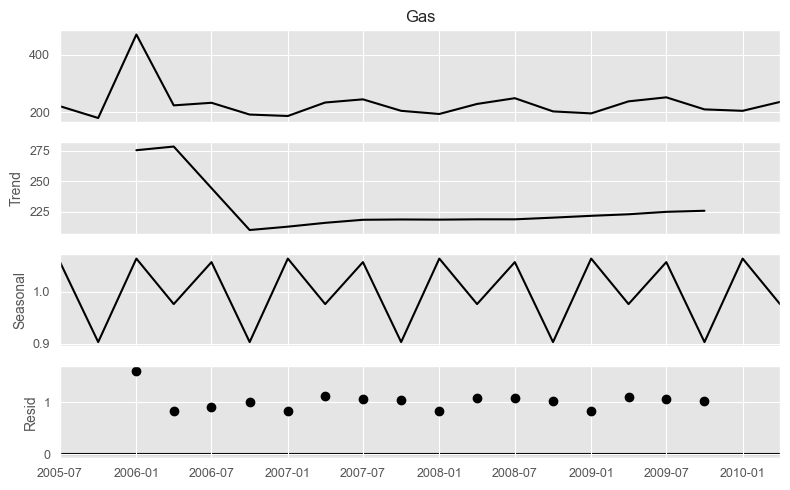

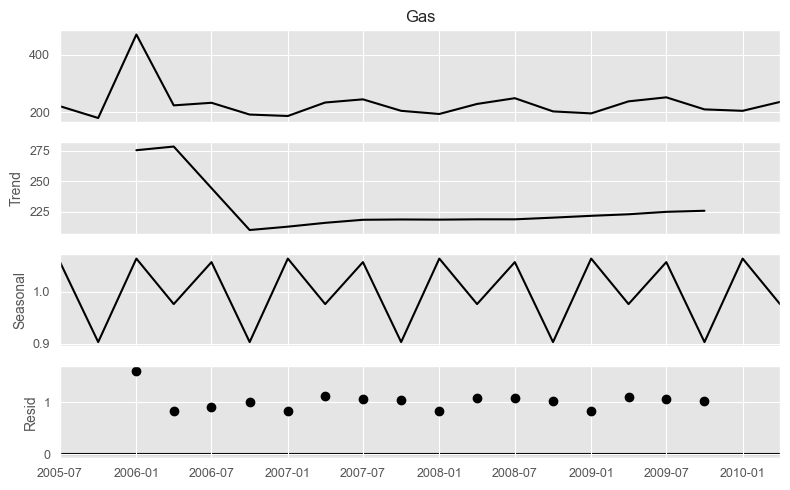

In [80]:
gas_outlier_decompose = seasonal_decompose(gas_copy, model="multiplicative")
gas_outlier_decompose.plot()

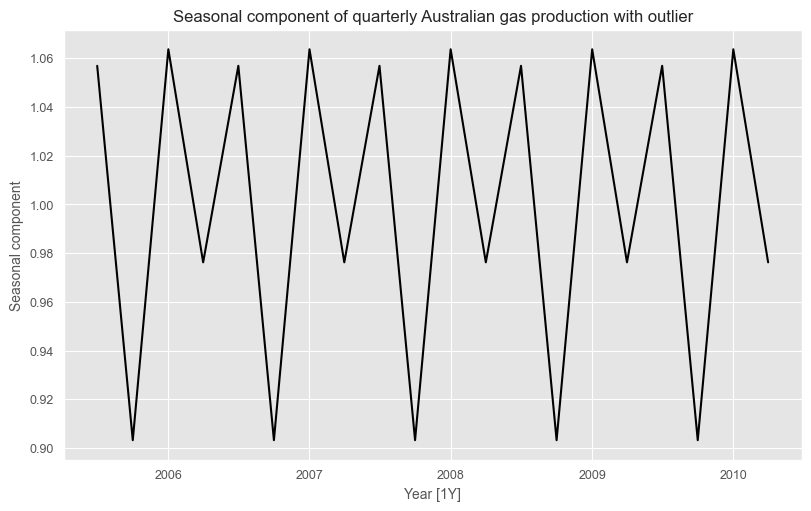

In [81]:
plt.plot(gas_outlier_decompose.seasonal)
plt.xlabel("Year [1Y]")
plt.ylabel("Seasonal component")
plt.title("Seasonal component of quarterly Australian gas production with outlier")
plt.show()

As we can see, the decomposition is affected by the outlier. This is because `stats_models.seasonal_decompose` uses a naive method which is not very robust to outliers. More complex methods are preferred in the case of large outliers. 